# OCT - TRUE - CUSTOM

## Installing and Importing Libraries

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.utils import class_weight 

1 Physical GPUs, 1 Logical GPUs


## Importing Dataset and Data Pre-Processing

In [2]:
data_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT/"
train_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT/train/'
test_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/OCT/OCT/test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

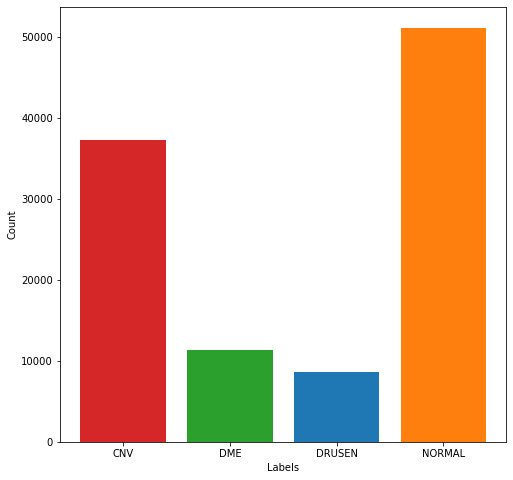

In [3]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Sample Images from the Dataset

Normal


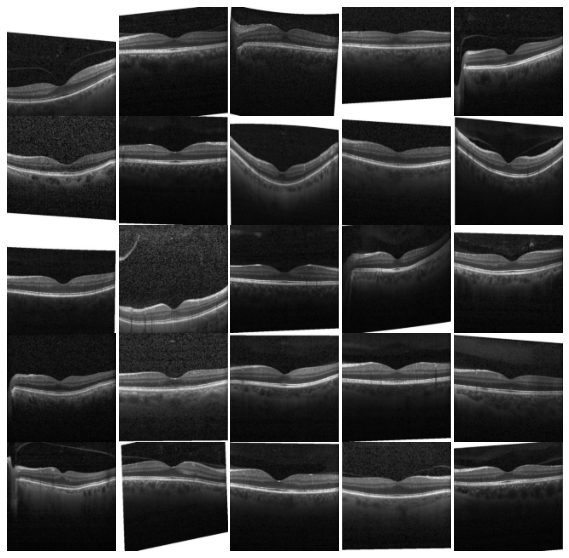

In [4]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


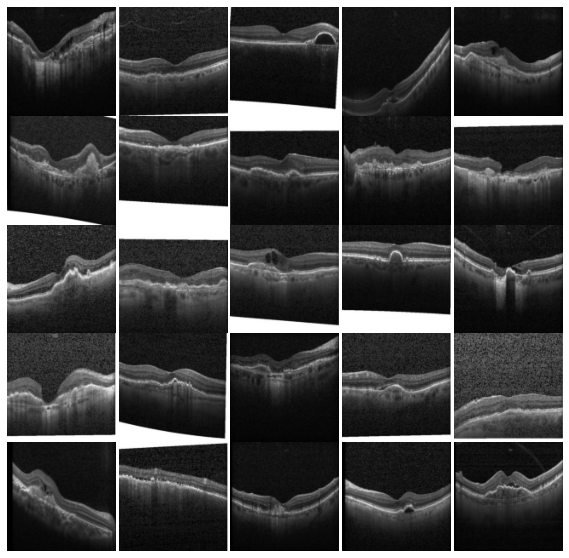

In [5]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


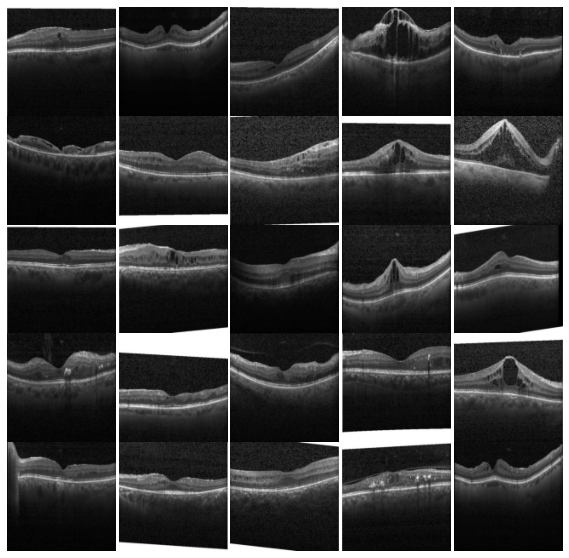

In [6]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


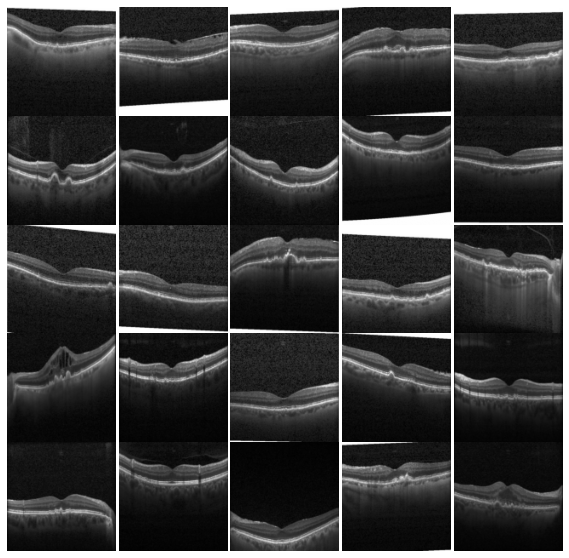

In [7]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [8]:
train_datagen = ImageDataGenerator(
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
)

In [9]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 108309 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [10]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)

### Image Data Augmentation

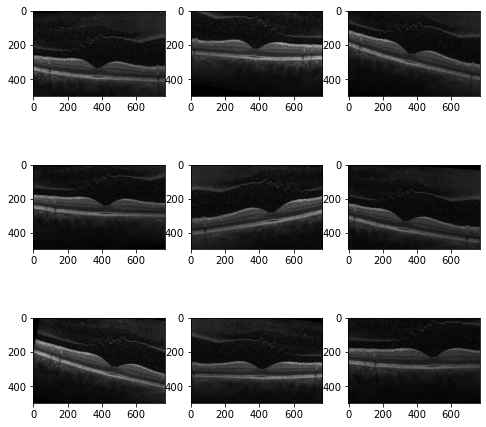

In [11]:
img = load_img(data_dir + 'train/NORMAL/NORMAL-1384-1.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image.astype('uint8'))

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [12]:
model = Sequential()
model.add(Conv2D(filters= 32 , kernel_size=(5,5), padding = 'same', activation = 'relu' , input_shape = (img_width, img_height,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

### VGG16 Architecture

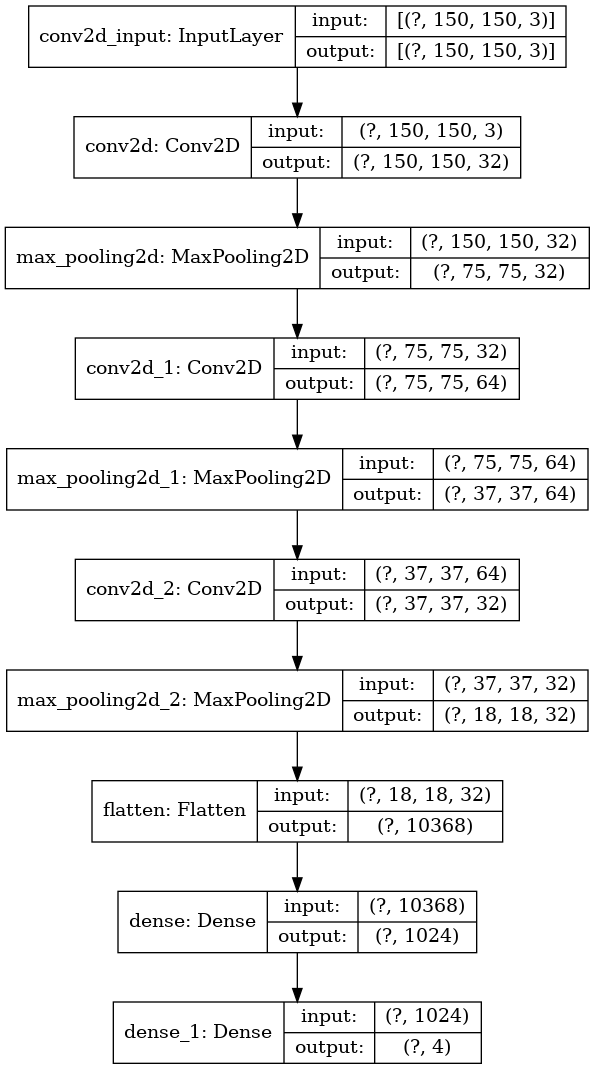

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Baseline Model Training

In [14]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [15]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(train_generator.classes), 
        train_generator.classes)
class_weights = dict(enumerate(class_weights))

callbacks = [checkpoint, csvlogger,reduceLR]


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [16]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = test_generator, 
    validation_steps = nb_test_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

Epoch 1/30
3384/3384 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.6199
Epoch 00001: val_loss improved from inf to 0.74707, saving model to baseline_model.h5
3384/3384 [==============================] - 605s 179ms/step - loss: 1.1422 - accuracy: 0.6199 - val_loss: 0.7471 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 2/30
3384/3384 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.7643
Epoch 00002: val_loss did not improve from 0.74707
3384/3384 [==============================] - 597s 177ms/step - loss: 0.6795 - accuracy: 0.7643 - val_loss: 0.9494 - val_accuracy: 0.7056 - lr: 1.0000e-04
Epoch 3/30
3384/3384 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.8194
Epoch 00003: val_loss improved from 0.74707 to 0.48441, saving model to baseline_model.h5
3384/3384 [==============================] - 604s 179ms/step - loss: 0.5368 - accuracy: 0.8194 - val_loss: 0.4844 - val_accuracy: 0.8518 - lr: 1.0000e-04
Epoch 4/30
3384/3

Epoch 26/30
3384/3384 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.9240
Epoch 00026: val_loss did not improve from 0.30508
3384/3384 [==============================] - 587s 173ms/step - loss: 0.2575 - accuracy: 0.9240 - val_loss: 0.4845 - val_accuracy: 0.8669 - lr: 1.0000e-11
Epoch 27/30
3384/3384 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9234
Epoch 00027: val_loss did not improve from 0.30508
3384/3384 [==============================] - 586s 173ms/step - loss: 0.2579 - accuracy: 0.9234 - val_loss: 0.4845 - val_accuracy: 0.8669 - lr: 1.0000e-11
Epoch 28/30
3384/3384 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9248
Epoch 00028: val_loss did not improve from 0.30508

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
3384/3384 [==============================] - 588s 174ms/step - loss: 0.2569 - accuracy: 0.9248 - val_loss: 0.4845 - val_accuracy: 0.8669 - lr: 1.0000e-11
Epoch 2

In [17]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

32/32 [==============================] - 3s 89ms/step - loss: 0.4826 - accuracy: 0.8670
Test Loss:  0.482572078704834
Test Accuracy:  0.8669999837875366


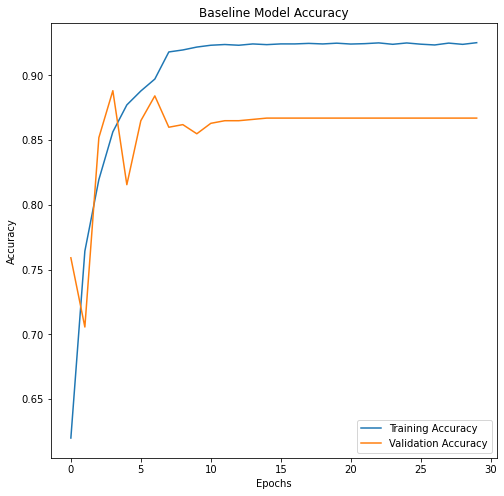

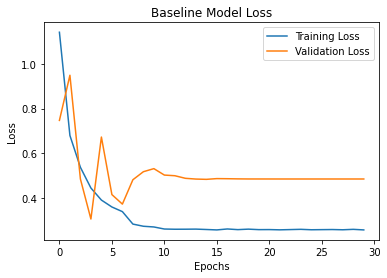

In [18]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

## Evaluations on Test Dataset

In [19]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

32/32 [==============================] - 3s 87ms/step - loss: 0.4826 - accuracy: 0.8670
Test Loss:  0.482572078704834
Test Accuracy:  0.8669999837875366


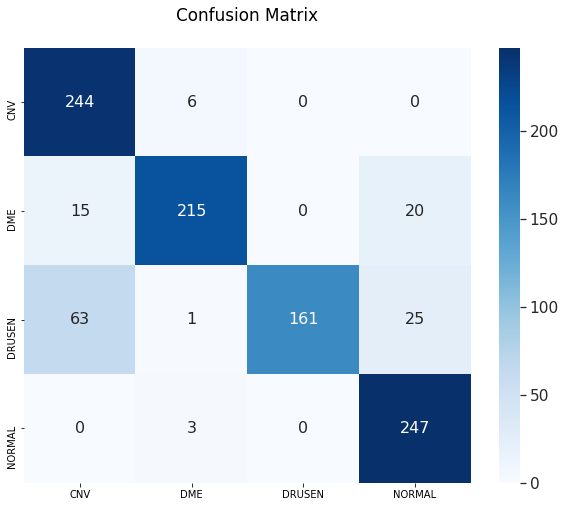

Classification Report

              precision    recall  f1-score   support

         CNV       0.76      0.98      0.85       250
         DME       0.96      0.86      0.91       250
      DRUSEN       1.00      0.64      0.78       250
      NORMAL       0.85      0.99      0.91       250

    accuracy                           0.87      1000
   macro avg       0.89      0.87      0.86      1000
weighted avg       0.89      0.87      0.86      1000



In [20]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))